# LAB 2

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from io import StringIO
import logging
import numpy as np
import pickle
import pandas as pd
import requests

# Третьи-парти библиотеки
import mlflow
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Библиотеки для визуализации данных
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

# Библиотеки для машинного обучения
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from tpot import TPOTClassifier
from fedot.api.main import Fedot

# MLflow-библиотеки
import mlflow.sklearn

### Загрузка данных

In [3]:
url = 'https://raw.githubusercontent.com/AI-is-out-there/data2lab/refs/heads/main/модуль 2 - датасет - практика.csv'

response = requests.get(url)
response.encoding = 'utf-8'  # Устанавливаем кодировку
data = StringIO(response.text)

df = pd.read_csv(data)
df

,subject_id,Count_subj,study_id,cart_id,Healthy_Status,eeg_time,eeg_date,report_0,report_1,report_2,...,filtering,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis
0,19557662,27,40000017,6848296,0,8:44 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,...,60 Hz notch Baseline filter,659,40,128,170,258,518,81,77,79
1,18477137,93,40000029,6848296,0,9:54 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,...,60 Hz notch Baseline filter,722,40,124,162,246,504,77,75,70
2,16598616,3,40000035,6376932,1,9:07 AM,28.06.2015,Sinus tachycardia,NaN,Normal ECG except for rate,...,60 Hz notch Baseline filter,600,40,130,162,244,474,79,72,77
3,16368287,7,40000079,6214760,1,5:14 PM,15.07.2015,Sinus rhythm,NaN,Normal ECG,...,60 Hz notch Baseline filter,659,40,146,180,254,538,79,66,69
4,18370366,2,40000084,6632385,0,1:52 PM,27.09.2015,Sinus rhythm,NaN,NaN,...,<not specified>,659,368,29999,504,590,868,84,80,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,19612562,29,40125255,6752764,1,11:26 AM,12.04.2016,Sinus rhythm,NaN,Normal ECG,...,60 Hz notch Baseline filter,606,40,162,204,298,526,64,68,66
9996,14816795,1,40125256,6555070,1,6:01 PM,12.04.2016,Sinus rhythm,NaN,Normal ECG,...,60 Hz notch Baseline filter,606,40,160,202,294,534,70,73,66
9997,11919067,4,40125266,6632385,0,9:58 AM,23.02.2014,Sinus rhythm,NaN,NaN,...,<not specified>,870,348,29999,506,586,882,49,64,49
9998,13871862,2,40125273,6848296,1,5:38 PM,03.01.2011,Sinus rhythm,NaN,Normal ECG,...,60 Hz notch Baseline filter,789,40,158,192,288,592,43,14,15


### Первичные анализ и предобработка данных

In [4]:
print(df.dtypes)
df.isna().sum()

subject_id          int64
Count_subj          int64
study_id            int64
cart_id             int64
Healthy_Status      int64
eeg_time           object
eeg_date           object
report_0           object
report_1           object
report_2           object
report_3           object
report_4           object
report_5           object
report_6           object
report_7           object
report_8           object
report_9           object
report_10          object
report_11          object
report_12          object
report_13          object
report_14          object
report_15         float64
report_16         float64
report_17         float64
bandwidth          object
filtering          object
rr_interval         int64
p_onset             int64
p_end               int64
qrs_onset           int64
qrs_end             int64
t_end               int64
p_axis              int64
qrs_axis            int64
t_axis              int64
dtype: object


subject_id            0
Count_subj            0
study_id              0
cart_id               0
Healthy_Status        0
eeg_time              0
eeg_date              0
report_0              0
report_1           2532
report_2           3532
report_3           5094
report_4           7218
report_5           8519
report_6           9326
report_7           9692
report_8           9886
report_9           9971
report_10          9983
report_11          9991
report_12          9999
report_13          9998
report_14          9999
report_15         10000
report_16         10000
report_17         10000
bandwidth             0
filtering             0
rr_interval           0
p_onset               0
p_end                 0
qrs_onset             0
qrs_end               0
t_end                 0
p_axis                0
qrs_axis              0
t_axis                0
dtype: int64

#### Удаление ненужных признаков

Полученные данные можно интерпретировать так, что по каждому наблюдению может быть несколько отчётов, в колонках report количество пропущенных занчений растёт с увеличением номера отчёта, данные колонки имеют строкорвый тип. Для будущего построения boxplot стоит оставить только числовые колонки. Также, нам не интересны идентификаторы, поэтому их можно удалить

In [5]:
df.drop(['subject_id', 'Count_subj', 'study_id', 'cart_id'], axis=1, inplace=True)

Выведем дополонительные статистические показатели

In [6]:
numb_cols = [x for x in df.columns if 'report' not in x and df.dtypes[x] != 'object']
df_wo_reports = df[numb_cols]

print(df_wo_reports.describe())
print('_'*60)
print(df['Healthy_Status'].value_counts())

       Healthy_Status   rr_interval      p_onset         p_end     qrs_onset  \
count    10000.000000  10000.000000  10000.00000  10000.000000  10000.000000   
mean         0.200700    880.614300   4781.92660   8930.689000    294.337500   
std          0.400544   1350.168399  10879.47242  13602.948503   1266.163235   
min          0.000000      0.000000     14.00000      0.000000      0.000000   
25%          0.000000    682.000000     40.00000    144.000000    188.000000   
50%          0.000000    810.000000     40.00000    158.000000    200.000000   
75%          0.000000    952.000000    329.00000  29999.000000    228.000000   
max          1.000000  29999.000000  29999.00000  29999.000000  29999.000000   

            qrs_end         t_end        p_axis      qrs_axis        t_axis  
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000  
mean     403.255900    697.381600   5077.596000    144.047600    227.735800  
std     1366.191721   1317.597859  11248.0709

Построим Boxplot на исходных данных

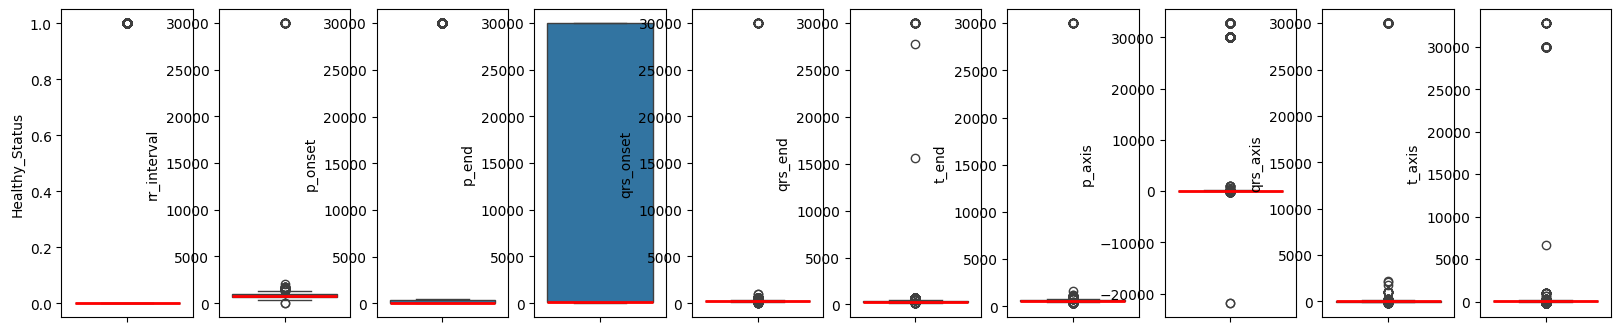

In [7]:
n = df_wo_reports.shape[1]
fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=True)
for i in range(n):
    plt.sca(ax[i])
    col = df_wo_reports.columns[i]
    sns.boxplot(y = df_wo_reports.iloc[:,i],data=df_wo_reports, medianprops={"color": "r", "linewidth": 2})

На части данных чётко видны выбросы, избавимся от них. Также, на всякий случай отсеем строки, в которых время начала волны или комплекса больше, чем конец (я, конечно, люблю фильм "Назад в будущее", но это не тот случай)

#### Удаление выбросов

In [8]:
outlier_columns = ['rr_interval', 'p_axis', 'p_end', 'p_onset', 'qrs_axis', 'qrs_end', 'qrs_onset', 't_axis', 't_end']
# Фильтруем данные, удаляя строки с значениями больше 2000 в выбранных столбцах
filtered_df = df.loc[
    (df[outlier_columns] < 2000).all(axis=1)
]
# Добавляем дополнительный фильтр для проверки логичности данных в столбцах 'p_onset' и 'qrs_onset'
filtered_df = filtered_df.query(
    '(p_onset < p_end) & (qrs_onset < qrs_end)'
)

filtered_df = filtered_df.rename(columns={'eeg_time ': 'eeg_time', 'eeg_date ': 'eeg_date'})
filtered_df.shape[0]

7046

In [9]:
filtered_df['p_onset'].value_counts()

40    7043
24       2
14       1
Name: p_onset, dtype: int64

Из value_counts колонки p_onset, можно сделать вывод, что данную колонку тоже можно убрать из выборки

In [10]:
filtered_df.drop(['p_onset'], axis=1, inplace=True)

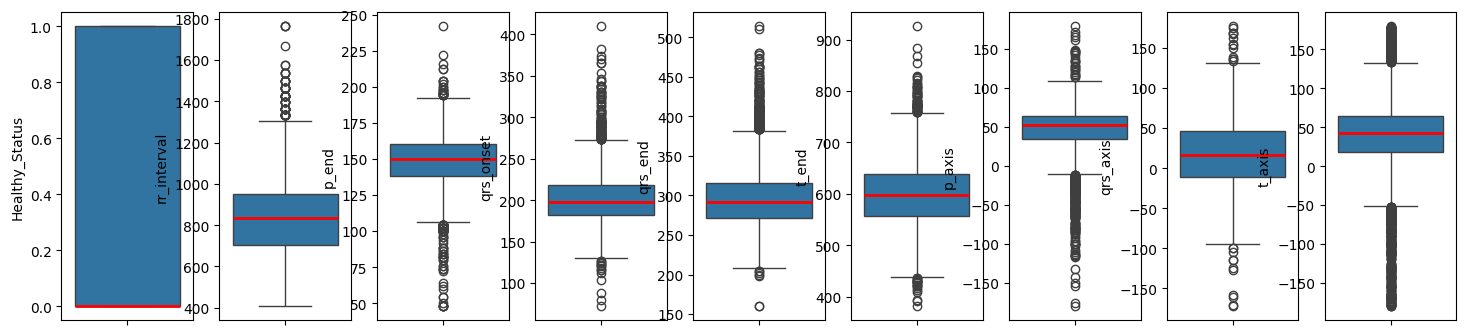

In [11]:
numb_cols = [x for x in filtered_df.columns if 'report' not in x and filtered_df.dtypes[x] != 'object']
n = filtered_df[numb_cols].shape[1]
fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=True)
for i in range(n):
    plt.sca(ax[i])
    col = filtered_df[numb_cols].columns[i]
    sns.boxplot(
        y = filtered_df[numb_cols].iloc[:,i],
        data=filtered_df[numb_cols],
        medianprops={"color": "r", "linewidth": 2}
    )

#### Обработка текстов

Касаемо текстов - в эталонном варианте предлагается сделать word2vec, а затем весь вектор схлопнуть до одного числа. Но из-за такого схлапывания можно потерять большое количество информации, поэтому мы построим полноценные эмбединги для тектов. Эмбединги будем строить, используя nlp-модель E5(EmbEddings from bidirEctional Encoder rEpresentations).

Соберём отчёты в один в рамках каждого из наблюдений.

In [12]:
# Создаем список названий столбцов для отчетов
report_columns = [f'report_{x}' for x in range(18)]

# Объединяем значения в столбцах отчетов в одну строку
filtered_df['report'] = filtered_df[report_columns].astype(str).agg(' '.join, axis=1)

# Очищаем данные от NaN и лишних пробелов
filtered_df['report'] = (
    filtered_df['report']
    .str.replace(r'\bnan\b', '', regex=True)
    .str.replace(r'\s+', ' ', regex=True)
    .str.strip()
)

# Удаляем остальные столбцы с отчетами
reports_to_drop = [f'report_{x}' for x in range(18)]
filtered_df.drop(reports_to_drop, axis=1, inplace=True)

filtered_df


,Healthy_Status,eeg_time,eeg_date,bandwidth,filtering,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,report
0,0,8:44 AM,27.06.2015,0.005-150 Hz,60 Hz notch Baseline filter,659,128,170,258,518,81,77,79,Sinus rhythm Possible right atrial abnormality...
1,0,9:54 AM,27.06.2015,0.005-150 Hz,60 Hz notch Baseline filter,722,124,162,246,504,77,75,70,Sinus rhythm Possible right atrial abnormality...
2,1,9:07 AM,28.06.2015,0.005-150 Hz,60 Hz notch Baseline filter,600,130,162,244,474,79,72,77,Sinus tachycardia Normal ECG except for rate
3,1,5:14 PM,15.07.2015,0.005-150 Hz,60 Hz notch Baseline filter,659,146,180,254,538,79,66,69,Sinus rhythm Normal ECG
6,1,12:54 PM,23.03.2016,0.005-150 Hz,60 Hz notch Baseline filter,952,146,198,282,598,24,80,20,Sinus rhythm Normal ECG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,1,8:39 AM,04.04.2016,0.005-150 Hz,60 Hz notch Baseline filter,769,166,214,302,592,55,60,68,Sinus rhythm Normal ECG
9995,1,11:26 AM,12.04.2016,0.005-150 Hz,60 Hz notch Baseline filter,606,162,204,298,526,64,68,66,Sinus rhythm Normal ECG
9996,1,6:01 PM,12.04.2016,0.005-150 Hz,60 Hz notch Baseline filter,606,160,202,294,534,70,73,66,Sinus rhythm Normal ECG
9998,1,5:38 PM,03.01.2011,0.005-150 Hz,60 Hz notch Baseline filter,789,158,192,288,592,43,14,15,Sinus rhythm Normal ECG


In [13]:
import re
import torch.nn.functional as F_torch

from torch import Tensor
from transformers import AutoTokenizer, AutoModel

task = 'Find the most similar report for a given report'
tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large-instruct')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-large-instruct')

def get_detailed_instruct(task_description: str, query: str) -> str:
    return f'Инструкуция: {task_description}\nЗапрос: {query}'

def text_normalization(text):
    '''
    Нормальзация текста - приведение к нижнему регистру,
    удаление лишних символов.
    '''
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.strip()
    return text

def average_pool(
    last_hidden_states: Tensor,
    attention_mask: Tensor
) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

def emb_calc(text):
    model.eval()
    
    text = text_normalization(get_detailed_instruct(task, text))
    input_texts = [text]
    
    # Tokenize the input texts
    batch_dict = tokenizer(input_texts, max_length=512, padding=True, truncation=True, return_tensors='pt')

    outputs = model(**batch_dict)
    embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
    # normalize embeddings
    embeddings = F_torch.normalize(embeddings, p=2, dim=1)
    
    return embeddings.flatten().tolist()


In [14]:
from tqdm import tqdm

tqdm.pandas()
filtered_df['report_embedding'] = filtered_df['report'].progress_apply(emb_calc)

print(filtered_df.shape)
filtered_df.head(3)

100%|██████████| 7046/7046 [18:20<00:00,  6.40it/s]

(7046, 15)


,Healthy_Status,eeg_time,eeg_date,bandwidth,filtering,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,report,report_embedding
0,0,8:44 AM,27.06.2015,0.005-150 Hz,60 Hz notch Baseline filter,659,128,170,258,518,81,77,79,Sinus rhythm Possible right atrial abnormality...,"[0.04227232187986374, 0.006614805199205875, -0..."
1,0,9:54 AM,27.06.2015,0.005-150 Hz,60 Hz notch Baseline filter,722,124,162,246,504,77,75,70,Sinus rhythm Possible right atrial abnormality...,"[0.04227232187986374, 0.006614805199205875, -0..."
2,1,9:07 AM,28.06.2015,0.005-150 Hz,60 Hz notch Baseline filter,600,130,162,244,474,79,72,77,Sinus tachycardia Normal ECG except for rate,"[0.018186617642641068, -0.009253554977476597, ..."


Посмотрим на дисбаланс классов в получившихся данных (Healthy_Status: 0 = пациент, 1 - условно здоровый)

2025-04-02 23:58:15,185 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-02 23:58:15,197 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


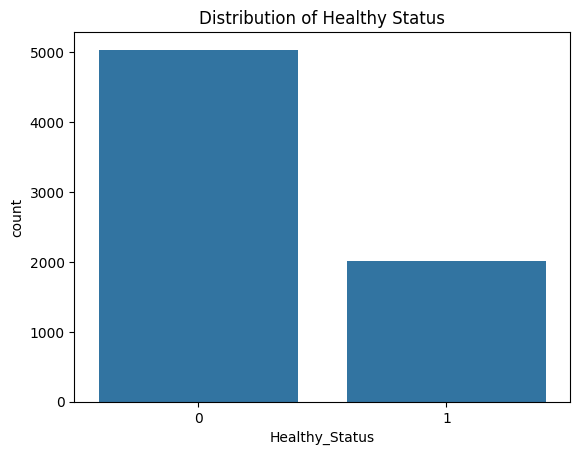

In [15]:
sns.countplot(data=filtered_df, x="Healthy_Status")
plt.title("Distribution of Healthy Status")
plt.show()

#### Оценка взаимосвязи данных датасета

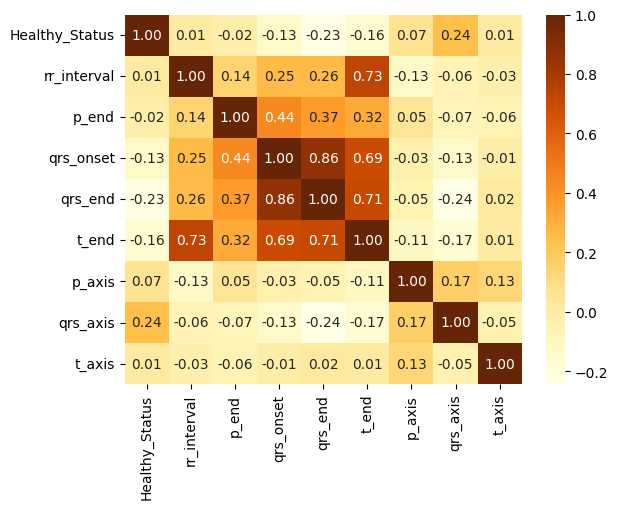

In [16]:
sns.heatmap(
    filtered_df.corr(),
    annot=True,
    fmt="0.2f",
    cmap='YlOrBr')
plt.show()

В таблице видна некоторая корреляция межу фичами времени (в милисекуцндах), явных корреляций, близких к 1, не обнаружено. Построим корреляционную матрицу с помощью pairplot

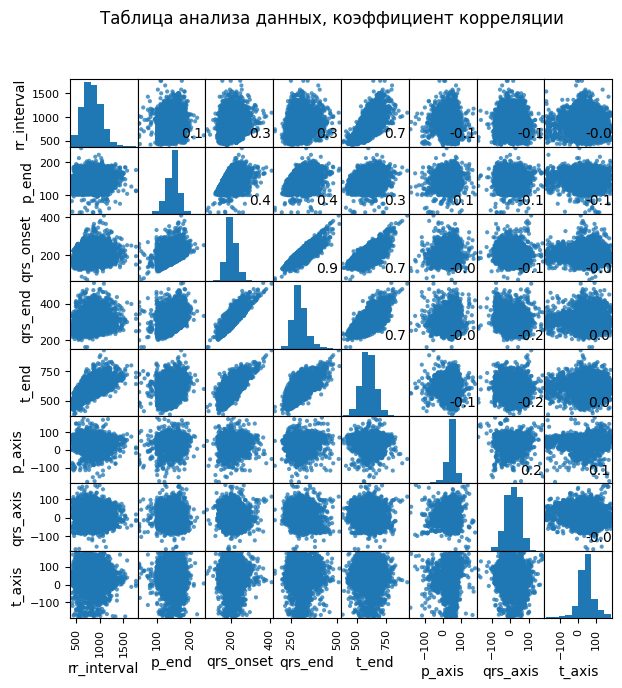

In [17]:
df = filtered_df.select_dtypes(include =[np.number]).copy() # keep only numerical columns
df.drop(columns=['Healthy_Status'], inplace=True)
# Remove rows and columns that would lead to df being singular
df = df.dropna(axis='columns')
df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
columnNames = list(df)
if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
    columnNames = columnNames[:10]
df = df[columnNames]
ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[7, 7], diagonal='hist')
corrs = df.corr().values
for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
    ax[i, j].annotate('%.1f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=10)
plt.suptitle('Таблица анализа данных, коэффициент корреляции')
plt.show()

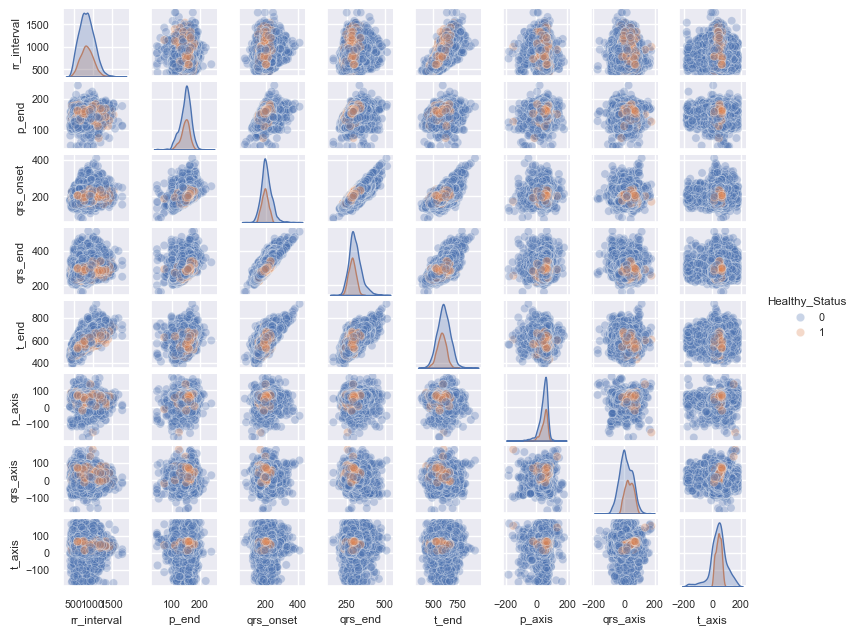

In [18]:
sns.set(font_scale=0.7)
sns.pairplot(
    filtered_df,
    hue = "Healthy_Status",
    height=0.8,
    aspect=1.2,
    plot_kws=dict(alpha=0.3)
)

Большая часть переменных имеет сильно перекрывающиеся распределения между классами, что говорит о том, что их будет сложно использовать по отдельности для хорошего разделения классов. Виден сильный дисбаланс классов

Развернём полученные ранее эмбединги

In [19]:
df_expanded = filtered_df['report_embedding'].apply(pd.Series)
df_expanded.columns = [f'embedding_{i+1}' for i in df_expanded.columns]
df_expanded = pd.concat([filtered_df.drop('report_embedding', axis=1), df_expanded], axis=1)

df_expanded.head(3)

,Healthy_Status,eeg_time,eeg_date,bandwidth,filtering,rr_interval,p_end,qrs_onset,qrs_end,t_end,...,embedding_1015,embedding_1016,embedding_1017,embedding_1018,embedding_1019,embedding_1020,embedding_1021,embedding_1022,embedding_1023,embedding_1024
0,0,8:44 AM,27.06.2015,0.005-150 Hz,60 Hz notch Baseline filter,659,128,170,258,518,...,-0.014705,-0.027275,0.019929,-0.033963,0.019968,0.002488,0.009422,-0.023444,-0.004205,0.008589
1,0,9:54 AM,27.06.2015,0.005-150 Hz,60 Hz notch Baseline filter,722,124,162,246,504,...,-0.014705,-0.027275,0.019929,-0.033963,0.019968,0.002488,0.009422,-0.023444,-0.004205,0.008589
2,1,9:07 AM,28.06.2015,0.005-150 Hz,60 Hz notch Baseline filter,600,130,162,244,474,...,-0.027245,-0.038788,0.002239,-0.036737,0.019546,0.012647,0.011644,-0.017534,-0.018541,0.009547


(7046, 1038) (7046, 2)
[0.19441412 0.10044111]
0.2948552311055088
2 components at 29.49% explained variance
3 components at 36.28% explained variance
4 components at 41.93% explained variance
5 components at 47.26% explained variance
6 components at 51.13% explained variance
7 components at 54.74% explained variance
8 components at 58.11% explained variance
9 components at 61.04% explained variance
10 components at 63.63% explained variance
11 components at 65.94% explained variance
12 components at 68.04% explained variance
13 components at 69.93% explained variance
14 components at 71.63% explained variance
15 components at 73.22% explained variance
16 components at 74.63% explained variance
17 components at 75.95% explained variance
18 components at 77.17% explained variance
19 components at 78.36% explained variance
20 components at 79.51% explained variance
21 components at 80.51% explained variance
22 components at 81.43% explained variance
23 components at 82.32% explained varia

Text(0, 0.5, 'Second Principal Component')

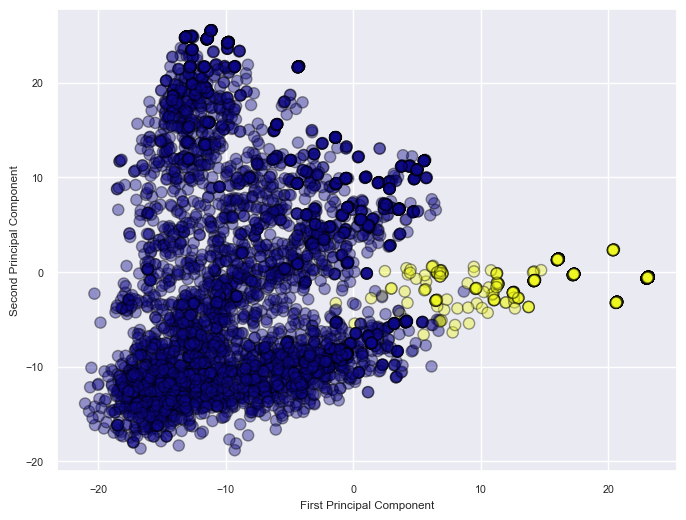

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


table_data_pca = df_expanded.select_dtypes(include =[np.number]).copy()
table_data_pca = table_data_pca.drop('Healthy_Status', axis = 1)

scaled_data = StandardScaler().fit(table_data_pca).transform(table_data_pca)
pca = PCA(n_components = 2).fit(scaled_data)
x_pca = pca.transform(scaled_data)
print(df_expanded.shape, x_pca.shape)

percent = pca.explained_variance_ratio_
print(percent)
print(sum(percent))

def pca_explained(X, threshold):
  features = X.shape[1]
  for i in range(2, features):
    pca = PCA(n_components = i).fit(X)
    sum_ = pca.explained_variance_ratio_
    # add all components explained variances
    percent = sum(sum_)
    print('{} components at {:.2f}% explained variance'.format(i,percent*100))
    if percent > threshold:
      break

pca_explained(scaled_data, 0.85)

plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0], x_pca[:,1], c=df_expanded['Healthy_Status'], cmap='plasma', alpha=0.4, edgecolors='black', s=65)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

Чёткого распределения кластеров без текстовой информвации не видно, добавление фичей эмбединга дало хорошие результаты. Из рисунка выше, следует, что классы могут быть довольно легко разделены. **И ГОРАЗДО ЛУЧШЕ, ЧЕМ В ЭТАЛОНННОМ ВАРИАНТЕ!**

Text(0, 0.5, 'Second Principal Component')

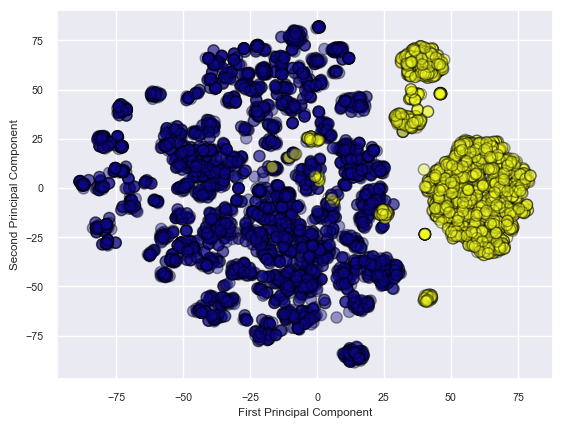

In [21]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state = 0)
scaled_data_tsne = tsne.fit_transform(scaled_data)
plt.scatter(scaled_data_tsne[:,0], scaled_data_tsne[:,1], c=df_expanded['Healthy_Status'], cmap='plasma', alpha=0.4, edgecolors='black', s=65)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')


Данный рисунок подкорепляет сделанные ранее выводы. Разделение произошло лучше, чем при PCA, что говорит, что данные имеют нелинейные зависимости, которые лучше разделяют классы

Time code evaluation for perplexity=1 in 26 sec
Time code evaluation for perplexity=5 in 24 sec
Time code evaluation for perplexity=10 in 26 sec
Time code evaluation for perplexity=15 in 29 sec
Time code evaluation for perplexity=20 in 30 sec
Time code evaluation for perplexity=30 in 32 sec
Time code evaluation for perplexity=40 in 35 sec
Time code evaluation for perplexity=50 in 37 sec
Time code evaluation for perplexity=100 in 48 sec


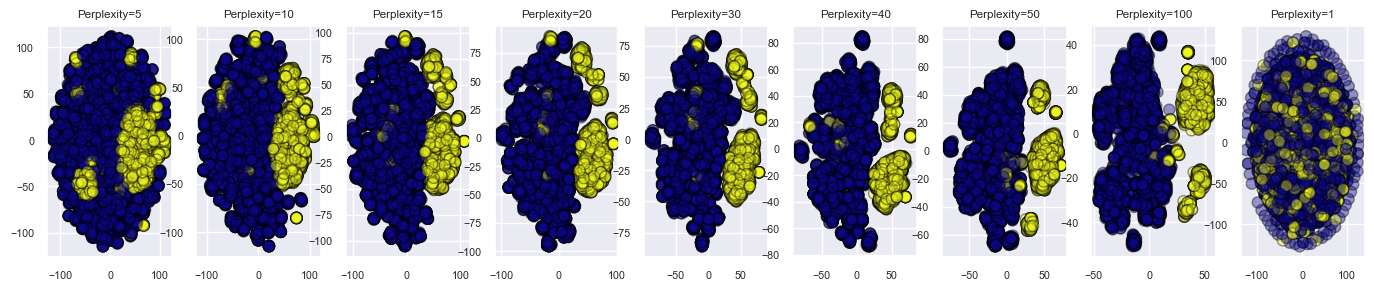

In [22]:
from sklearn import manifold
from time import time

n_components = 2
perplexities = [1, 5, 10, 15, 20, 30, 40, 50, 100]

(fig, subplots) = plt.subplots(1, len(perplexities), figsize=(17, 3))

for i, perplexity in enumerate(perplexities):
    ax = subplots[i-1]

    t0 = time()
    tsne = manifold.TSNE(
        n_components=n_components,
        init="random",
        random_state=0,
        perplexity=perplexity,
    )

    scaled_data_tsne = tsne.fit_transform(scaled_data)
    t1 = time()

    print("Time code evaluation for perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(
        scaled_data_tsne[:,0],
        scaled_data_tsne[:,1],
        c=df_expanded['Healthy_Status'],
        cmap='plasma',
        alpha=0.4,
        edgecolors='black',
        s=65
    )
    ax.axis("tight")

Визуализация показывает, что:
- Локальная структура (мелкие кластеры) доминирует при малых perplexity.
- Глобальная структура (крупные группы) проявляется при больших perplexity.
- Оптимальный результат достигается в среднем диапазоне (15–30), где кластеры хорошо различимы.

#### Обогащение датасета, восстановление баланса классов

Из анализа выше ясно, что наибольший вклад дают эмбединги отчётов, поэтому можно безболезненно избывиться от всех других текстовых данных. Это также обеспечит более простую работу с autoML методами и методами обогащения датасета

In [23]:
df_expanded = df_expanded.select_dtypes(include =[np.number])
df_expanded.head(3)

,Healthy_Status,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,embedding_1,...,embedding_1015,embedding_1016,embedding_1017,embedding_1018,embedding_1019,embedding_1020,embedding_1021,embedding_1022,embedding_1023,embedding_1024
0,0,659,128,170,258,518,81,77,79,0.042272,...,-0.014705,-0.027275,0.019929,-0.033963,0.019968,0.002488,0.009422,-0.023444,-0.004205,0.008589
1,0,722,124,162,246,504,77,75,70,0.042272,...,-0.014705,-0.027275,0.019929,-0.033963,0.019968,0.002488,0.009422,-0.023444,-0.004205,0.008589
2,1,600,130,162,244,474,79,72,77,0.018187,...,-0.027245,-0.038788,0.002239,-0.036737,0.019546,0.012647,0.011644,-0.017534,-0.018541,0.009547


Избавимся от дисбаланса классов при помощи метода SMOTE, упомянутого в ноутбуке с первой задачей(IRIS)

In [24]:
from imblearn.over_sampling import SMOTE

target_column = 'Healthy_Status'

smote = SMOTE(random_state=42)
X_expanded = df_expanded.drop(target_column, axis=1)
y_expanded = df_expanded[target_column]

X_resampled, y_resampled = smote.fit_resample(X_expanded, y_expanded)

resampled_df = pd.DataFrame(X_resampled, columns=X_expanded.columns)
resampled_df[target_column] = y_resampled

print(resampled_df[target_column].value_counts())
resampled_df.head(3)

0    5039
1    5039
Name: Healthy_Status, dtype: int64


,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,embedding_1,embedding_2,...,embedding_1016,embedding_1017,embedding_1018,embedding_1019,embedding_1020,embedding_1021,embedding_1022,embedding_1023,embedding_1024,Healthy_Status
0,659,128,170,258,518,81,77,79,0.042272,0.006615,...,-0.027275,0.019929,-0.033963,0.019968,0.002488,0.009422,-0.023444,-0.004205,0.008589,0
1,722,124,162,246,504,77,75,70,0.042272,0.006615,...,-0.027275,0.019929,-0.033963,0.019968,0.002488,0.009422,-0.023444,-0.004205,0.008589,0
2,600,130,162,244,474,79,72,77,0.018187,-0.009254,...,-0.038788,0.002239,-0.036737,0.019546,0.012647,0.011644,-0.017534,-0.018541,0.009547,1


Text(0, 0.5, 'Second Principal Component')

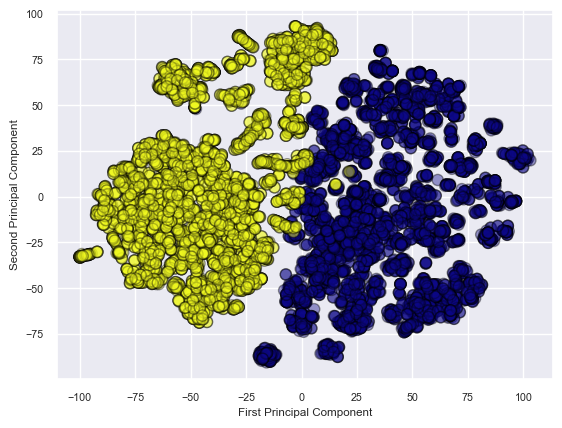

In [25]:
tsne_data = (
    resampled_df
    .select_dtypes(include =[np.number])
    .drop('Healthy_Status', axis = 1).copy()
)

scaled_data = StandardScaler().fit(tsne_data).transform(tsne_data)
tsne = TSNE(random_state = 0)
scaled_data_tsne = tsne.fit_transform(scaled_data)

plt.scatter(scaled_data_tsne[:,0], scaled_data_tsne[:,1], c=resampled_df['Healthy_Status'], cmap='plasma', alpha=0.4, edgecolors='black', s=65)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

Как видно на рисунке выше, дисбаланс классов устранён, сохраним получившиеся данные и приступим к обучению моделей

In [26]:
resampled_df.to_parquet('processed_data.parquet', index=False)

resampled_df = pd.read_parquet('processed_data.parquet')
resampled_df.head(3)

,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,embedding_1,embedding_2,...,embedding_1016,embedding_1017,embedding_1018,embedding_1019,embedding_1020,embedding_1021,embedding_1022,embedding_1023,embedding_1024,Healthy_Status
0,659,128,170,258,518,81,77,79,0.042272,0.006615,...,-0.027275,0.019929,-0.033963,0.019968,0.002488,0.009422,-0.023444,-0.004205,0.008589,0
1,722,124,162,246,504,77,75,70,0.042272,0.006615,...,-0.027275,0.019929,-0.033963,0.019968,0.002488,0.009422,-0.023444,-0.004205,0.008589,0
2,600,130,162,244,474,79,72,77,0.018187,-0.009254,...,-0.038788,0.002239,-0.036737,0.019546,0.012647,0.011644,-0.017534,-0.018541,0.009547,1


# LAB3 AutoML

In [27]:
target_column = 'Healthy_Status'

X = resampled_df.drop(target_column, axis=1)
y = resampled_df[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
import os

directory = 'autoML_models'
if not os.path.exists(directory):
    os.makedirs(directory)
    print(f'directory "{directory}" was created')
else:
    print(f'directory "{directory}" already exists')

directory "autoML_models" already exists


### Lama

In [29]:
task = Task('multiclass')

automl = TabularAutoML(
    task=task,
    cpu_limit=-1,
    general_params={'use_algos': 'auto'},
    reader_params={'cv': 3, 'random_state': 42}
)

train_data = pd.concat([X_train, y_train], axis=1)
roles = {
    'target': target_column,
    'drop': []
}

oof_pred = automl.fit_predict(
    train_data=train_data,
    roles=roles,
    verbose=1
)

test_pred = automl.predict(X_test)
y_pred = test_pred.data.argmax(axis=1)

accuracy, precision, recall = (
    accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred, average='weighted'),
    recall_score(y_test, y_pred, average='weighted'),
)

clear_output(wait=False)
print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

Accuracy: 1.0, Precision: 1.0, Recall: 1.0


In [30]:
with open(f'{directory}/lightautoml_electrocardiogram_m2_model.pkl', 'wb') as f:
    pickle.dump(automl, f)

with open(f'{directory}/lightautoml_electrocardiogram_m2_model.pkl', 'rb') as f:
    loaded_automl = pickle.load(f)

new_pred = loaded_automl.predict(X_test).data.argmax(axis=1)
accuracy, precision, recall = (
    accuracy_score(y_test, new_pred),
    precision_score(y_test, new_pred, average='weighted'),
    recall_score(y_test, new_pred, average='weighted'),
)
print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

Accuracy: 1.0, Precision: 1.0, Recall: 1.0


In [31]:
try:
    algo = loaded_automl.levels[0][0].ml_algos[0]
    print(f"Тип алгоритма: {type(algo).__name__}")
    
    if hasattr(algo, 'models'):
        model = algo.models[0]
        print(f"Тип модели: {type(model).__name__}")
        attrs_to_show = [attr for attr in dir(model) if not attr.startswith('_')]

        print(f"\n=== Параметры {type(model).__name__} ===")
        for attr in attrs_to_show:
            try:
                value = getattr(model, attr)
                
                if attr == 'model':
                    print("\nАрхитектура нейросети:")
                    print(value)
                elif attr == 'loss':
                    print(f"\nФункция потерь: {value.__class__.__name__}")
                else:
                    print(f"{attr}: {value}")
                    
            except Exception as e:
                print(f"{attr}: [не доступен]")

except Exception as e:
    print(f"Ошибка: {str(e)}")
    print("Используйте альтернативный метод:")
    print(loaded_automl.print_model_info())




Тип алгоритма: LinearLBFGS
Тип модели: TorchBasedLogisticRegression

=== Параметры TorchBasedLogisticRegression ===
categorical_idx: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
cs: [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]
data_size: 2544
early_stopping: 2
embed_sizes: [ 9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9 11]
fit: <bound method TorchBasedLinearEstimator.fit of <lightautoml.ml_algo.torch_based.linear_model.TorchBasedLogisticRegression object at 0x00000131D9B7A9D0>>

Функция потерь: TorchLossWrapper
max_iter: 100
metric: <lightautoml.tasks.losses.base.MetricFunc object at 0x00000131ACA02F10>

Архитектура нейросети:
CatMulticlass(
  (linear): Linear(in_features=2516, out_features=2, bias=False)
  (final_act): SoftmaxClip(
    (smax): Softmax(dim=1)
  )
)
output_size: 2
predict: <bound method TorchBasedLo

### Fedot

In [32]:
# Инициализация Fedot с явным указанием доступных моделей
automl_model = Fedot(
    problem='classification',
    preset='fast_train',
    # timeout=10,  # 2 минуты на подбор
    available_operations=['rf', 'logit','mlp', 'xgboost'],
    logging_level=logging.CRITICAL,
    with_tuning=True,
    n_jobs=-1,
    seed=42
)

try:
    pipeline = automl_model.fit(features=X_train, target=y_train)
    
    y_pred = automl_model.predict(features=X_test)
    
    accuracy, precision, recall = (
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred, average='weighted'),
        recall_score(y_test, y_pred, average='weighted'),
    )
    print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

    
except Exception as e:
    print(f'Произошла ошибка: {str(e)}')
    print('Попробуйте обновить Fedot или использовать другой пресет')

2025-04-03 00:23:34,293 - Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
Accuracy: 0.9995039682539683, Precision: 0.9995044465873781, Recall: 0.9995039682539683


In [33]:
def get_pipeline_info(pipeline):
    """Рекурсивно получает информацию о пайплайне"""
    info = []
    
    def process_node(node, level=0):
        node_info = {
            'type': str(node.operation.operation_type),
            'params': getattr(node, 'parameters', {}),
            'level': level,
            'node_object': node  # Сохраняем сам объект узла
        }
        info.append(node_info)
        
        if hasattr(node, 'nodes_from'):
            for parent in node.nodes_from:
                process_node(parent, level + 1)
    
    process_node(pipeline.root_node if hasattr(pipeline, 'root_node') else pipeline)
    return info

best_pipeline = automl_model.current_pipeline
pipeline_info = get_pipeline_info(best_pipeline)

for item in pipeline_info:
    print(f"{'  ' * item['level']}Узел: {item['type']}")
    print(f"{'  ' * item['level']}Параметры: {item['params']}")
    
    node = item['node_object']
    try:
        if hasattr(node, 'fitted_operation'):
            fitted_params = node.fitted_operation.get_params()
            print('Fitted_params: {')
            for param in fitted_params:
                print(f'\t{param}: {fitted_params[param]}')
            print('}')
    except Exception as e:
        print(f'Не удалось получить fitted параметры: {str(e)}')

Узел: mlp
Параметры: {}
Fitted_params: {
	activation: relu
	alpha: 0.0001
	batch_size: auto
	beta_1: 0.9
	beta_2: 0.999
	early_stopping: False
	epsilon: 1e-08
	hidden_layer_sizes: (100,)
	learning_rate: constant
	learning_rate_init: 0.001
	max_fun: 15000
	max_iter: 200
	momentum: 0.9
	n_iter_no_change: 10
	nesterovs_momentum: True
	power_t: 0.5
	random_state: None
	shuffle: True
	solver: adam
	tol: 0.0001
	validation_fraction: 0.1
	verbose: False
	warm_start: False
}


In [34]:
with open(f'{directory}/fedot_model.pkl', 'wb') as f:
    pickle.dump(automl_model, f)

with open(f'{directory}/fedot_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

y_pred = loaded_model.predict(features=X_test)

accuracy, precision, recall = (
    accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred, average='weighted'),
    recall_score(y_test, y_pred, average='weighted'),
)
print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

Accuracy: 0.9995039682539683, Precision: 0.9995044465873781, Recall: 0.9995039682539683


### TPOT

In [35]:
tpot = TPOTClassifier(generations=4, population_size=10, random_state=42, verbosity=2, n_jobs=-1, max_time_mins=30, cv=3)
tpot.fit(X_train, y_train)

Version 0.12.1 of tpot is outdated. Version 1.0.0 was released Wednesday February 26, 2025.


                                                                            
Generation 1 - Current best internal CV score: 0.999255721625581
                                                                            
Generation 2 - Current best internal CV score: 0.999255721625581
                                                                            
Generation 3 - Current best internal CV score: 0.9995038298007456
                                                                            
Generation 4 - Current best internal CV score: 0.9995038298007456
                                                          
Best pipeline: RandomForestClassifier(GradientBoostingClassifier(input_matrix, learning_rate=1.0, max_depth=1, max_features=0.6000000000000001, min_samples_leaf=19, min_samples_split=19, n_estimators=100, subsample=0.7000000000000001), bootstrap=True, criterion=gini, max_features=0.2, min_samples_leaf=8, min_samples_split=4, n_estimators=100)


TPOTClassifier(cv=3, generations=4, max_time_mins=30, n_jobs=-1,
               population_size=10, random_state=42, verbosity=2)

In [36]:
y_pred = tpot.predict(X_test)
accuracy, precision, recall = (
    accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred, average='weighted'),
    recall_score(y_test, y_pred, average='weighted'),
)

print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

Accuracy: 1.0, Precision: 1.0, Recall: 1.0


In [37]:
from joblib import dump

final_pipeline = tpot.fitted_pipeline_

dump(final_pipeline, f'{directory}/tpot_final_pipeline.joblib')

from joblib import load
from sklearn.metrics import accuracy_score

loaded_pipeline = load(f'{directory}/tpot_final_pipeline.joblib')

y_pred = loaded_pipeline.predict(X_test)
accuracy, precision, recall = (
    accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred, average='weighted'),
    recall_score(y_test, y_pred, average='weighted'),
)

print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

Accuracy: 1.0, Precision: 1.0, Recall: 1.0


In [38]:
for step_name, step_estimator in loaded_pipeline.steps:
    print(f"Тип: {type(step_estimator).__name__}")
    params = step_estimator.get_params()
    print("Параметры:")
    for el in params:
        print(f'\t{el}: {params[el]}')

Тип: StackingEstimator
Параметры:
	estimator__ccp_alpha: 0.0
	estimator__criterion: friedman_mse
	estimator__init: None
	estimator__learning_rate: 1.0
	estimator__loss: log_loss
	estimator__max_depth: 1
	estimator__max_features: 0.6000000000000001
	estimator__max_leaf_nodes: None
	estimator__min_impurity_decrease: 0.0
	estimator__min_samples_leaf: 19
	estimator__min_samples_split: 19
	estimator__min_weight_fraction_leaf: 0.0
	estimator__n_estimators: 100
	estimator__n_iter_no_change: None
	estimator__random_state: 42
	estimator__subsample: 0.7000000000000001
	estimator__tol: 0.0001
	estimator__validation_fraction: 0.1
	estimator__verbose: 0
	estimator__warm_start: False
	estimator: GradientBoostingClassifier(learning_rate=1.0, max_depth=1,
                           max_features=0.6000000000000001, min_samples_leaf=19,
                           min_samples_split=19, random_state=42,
                           subsample=0.7000000000000001)
Тип: RandomForestClassifier
Параметры:
	bootst

Как видно по метрикам, все модели успешно справились с поставленной задачей. Лучше всех в этот раз справилась Lama

# Lab4 MLFlow

Подготовка примеров для проверки решения целевой задачи по прогнозированию и оценка качества моделей была проведена выше.
Метрики полученных ранее моделей имеют максимальное значние, так как задача классификации Iris крайне проста. В связи с этим.

Перейдём к визуализации

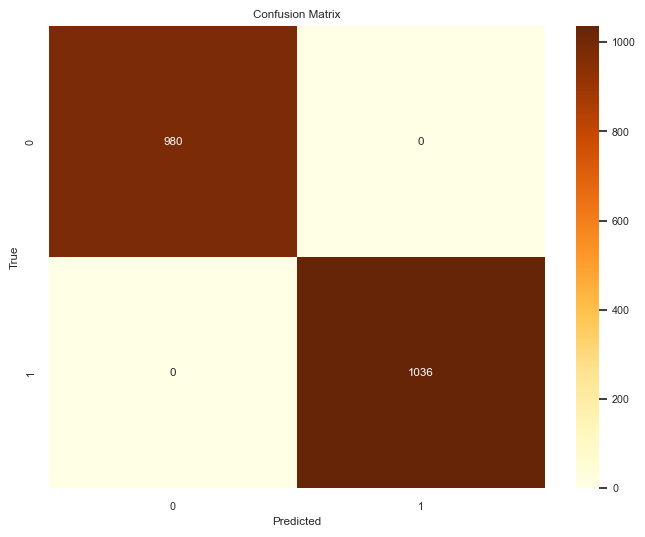

In [39]:
# После получения предсказаний (y_test и y_pred из предыдущего кода)
with open(f'{directory}/lightautoml_electrocardiogram_m2_model.pkl', 'rb') as f:
    loaded_automl = pickle.load(f)

y_pred = loaded_automl.predict(X_test).data.argmax(axis=1)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr', 
            xticklabels=df_expanded[target_column].unique(),
            yticklabels=df_expanded[target_column].unique())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Как видно, модель действительно делает идеально точные прогнозы

### Развертывание модели в MLFlow

1. Вводим в командную строку: `mlflow server --host 127.0.0.1 --port 8080`
2. Переходим по адресу: `http://127.0.0.1:8080`

Продемонстрируем работу с MLFlow на примере Lama

In [40]:
def collect_model_info(loaded_automl):
    model_info = {
        'algorithm_type': None,
        'model_type': None,
        'parameters': {},
        'architecture': None,
        'loss_function': None,
        'error': None,
        'alternative_info': None
    }
    
    try:
        algo = loaded_automl.levels[0][0].ml_algos[0]
        model_info['algorithm_type'] = type(algo).__name__
        
        if hasattr(algo, 'models'):
            model = algo.models[0]
            model_info['model_type'] = type(model).__name__
            attrs_to_show = [attr for attr in dir(model) if not attr.startswith('_')]

            for attr in attrs_to_show:
                try:
                    value = getattr(model, attr)
                    
                    if attr == 'model':
                        model_info['architecture'] = str(value)
                    elif attr == 'loss':
                        model_info['loss_function'] = value.__class__.__name__
                    else:
                        model_info['parameters'][attr] = str(value)
                        
                except Exception as e:
                    model_info['parameters'][attr] = '[не доступен]'

    except Exception as e:
        model_info['error'] = str(e)
        model_info['alternative_info'] = str(loaded_automl.print_model_info())
    
    return model_info

In [41]:
mlflow.set_tracking_uri("http://127.0.0.1:8080")
mlflow.set_experiment("ECG_Classification")  # Название эксперимента

params = {
    'task': 'multiclass',
    'cpu_limit': -1,
    'general_params': {'use_algos': 'auto'},
    'reader_params': {'cv': 3, 'random_state': 42}
}

roles = {
    'target': target_column,
    'drop': []
}
# Старт трекинга в MLflow
with mlflow.start_run():
    # Логирование параметров
    mlflow.log_params(params)
    mlflow.log_params(roles)
    # Инициализация и обучение модели
    automl = TabularAutoML(
        task=Task(params['task']),
        cpu_limit=params['cpu_limit'],
        general_params=params['general_params'],
        reader_params=params['reader_params']
    )
    
    train_data = pd.concat([X_train, y_train], axis=1)
    oof_pred = automl.fit_predict(train_data, roles=roles, verbose=1)

    # Предсказание на тестовых данных
    test_pred = automl.predict(X_test)
    y_pred = test_pred.data.argmax(axis=1)

    # Расчет метрик
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    mlflow.log_metrics({
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall
    })
    clear_output(wait=False)
    print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

    # Сохранение модели в MLflow
    mlflow.sklearn.log_model(automl, "lightautoml_model")
    # Дополнительное сохранение в .pkl (опционально)
    with open(f'{directory}/lightautoml_electrocardiogram_m2_model.pkl', 'wb') as f:
        pickle.dump(automl, f)
    mlflow.log_artifact(f'{directory}/lightautoml_electrocardiogram_m2_model.pkl')

    model_info = collect_model_info(loaded_automl)
    mlflow.log_param("algorithm_type", model_info['algorithm_type'])
    mlflow.log_param("model_type", model_info['model_type'])
    mlflow.log_param("loss_function", model_info['loss_function'])
    
    if model_info['architecture']:
        mlflow.log_text(model_info['architecture'], "model_architecture.txt")
    
    for param, value in model_info['parameters'].items():
        mlflow.log_param(f"param_{param}", value)
    
    if model_info['error']:
        mlflow.log_param("error", model_info['error'])
        mlflow.log_text(model_info['alternative_info'], "alternative_model_info.txt")
    

Accuracy: 1.0, Precision: 1.0, Recall: 1.0


2025/04/03 01:19:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/04/03 01:19:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run nebulous-fish-446 at: http://127.0.0.1:8080/#/experiments/597488099350027753/runs/97dc07c628384fb1987d907be76bd761.
2025/04/03 01:19:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/597488099350027753.
